**Author**: Andy Tzanidakis \
**Last updated**: May 15, 2024

## Overview

In this notebook we will learn how to use the outputs from LSDB catalogs and use `ensamble` from TAPE to compute time-series features.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
import numpy as np
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

import lsdb
import dask

# Configurations for dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


## Initialize hipscat catalogs

In [2]:
%%time
gaia = lsdb.read_hipscat("https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/gaia_dr3/gaia", 
                            columns=['ra', 'dec', 'parallax'])

# load ZTF object table
ztf = lsdb.read_hipscat("https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_dr14/",
                             columns=['ra', 'dec', 'ps1_objid'])

# Load ZTF DR14 zources
ztf_sources = lsdb.read_hipscat("https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_source/",
                            columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'])

CPU times: user 12.4 s, sys: 1.44 s, total: 13.8 s
Wall time: 15.5 s


## Cone Search 

In [5]:
%%time

# Cone search around a given position
ra, dec = 132.8460000, +11.8140000
rad = 5_000  # in arcsec (rougly 1.5 deg)

_sample = ztf.cone_search(ra=ra,
    dec=dec,
    radius_arcsec=rad).crossmatch(gaia, radius_arcsec=2, require_right_margin=False).compute()

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


CPU times: user 3.62 s, sys: 2.03 s, total: 5.65 s
Wall time: 1.81 s


In [6]:
_sample

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec
_hipscat_index,,,,,,,
1195635224533270528,133.233700,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933
1195635242824630272,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202
1195635245353795584,133.225766,10.486782,120581332257664629,133.225770,10.486761,0.777203,0.077445
1195681424221405184,133.356580,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692
1195681461315829760,133.379456,10.529030,120631333794875301,133.379471,10.529019,<NA>,0.067189
...,...,...,...,...,...,...,...
1216416656180379648,132.783272,13.193240,123831327832352378,132.783269,13.193228,<NA>,0.044713
1216420518253559808,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951
1216420530047942656,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055


In [7]:
print (f"Number of objects in crossmatch: {len(_sample)}")

Number of objects in crossmatch: 36621


In [8]:
_sample.head(1)

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec
_hipscat_index,,,,,,,
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933


In [9]:
%%time
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _sample, 
    ra_column="ra_ztf_dr14", 
    dec_column="dec_ztf_dr14", 
    lowest_order=5 # set lowest hipsscat order N=5 for sample
)

CPU times: user 53.9 s, sys: 265 ms, total: 54.2 s
Wall time: 54.3 s


In [10]:
_sample_hips

,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,Norder,Dir,Npix
npartitions=6,,,,,,,,,,
1194579801160024064,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
1196831600973709312,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
1215971899390033920,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...


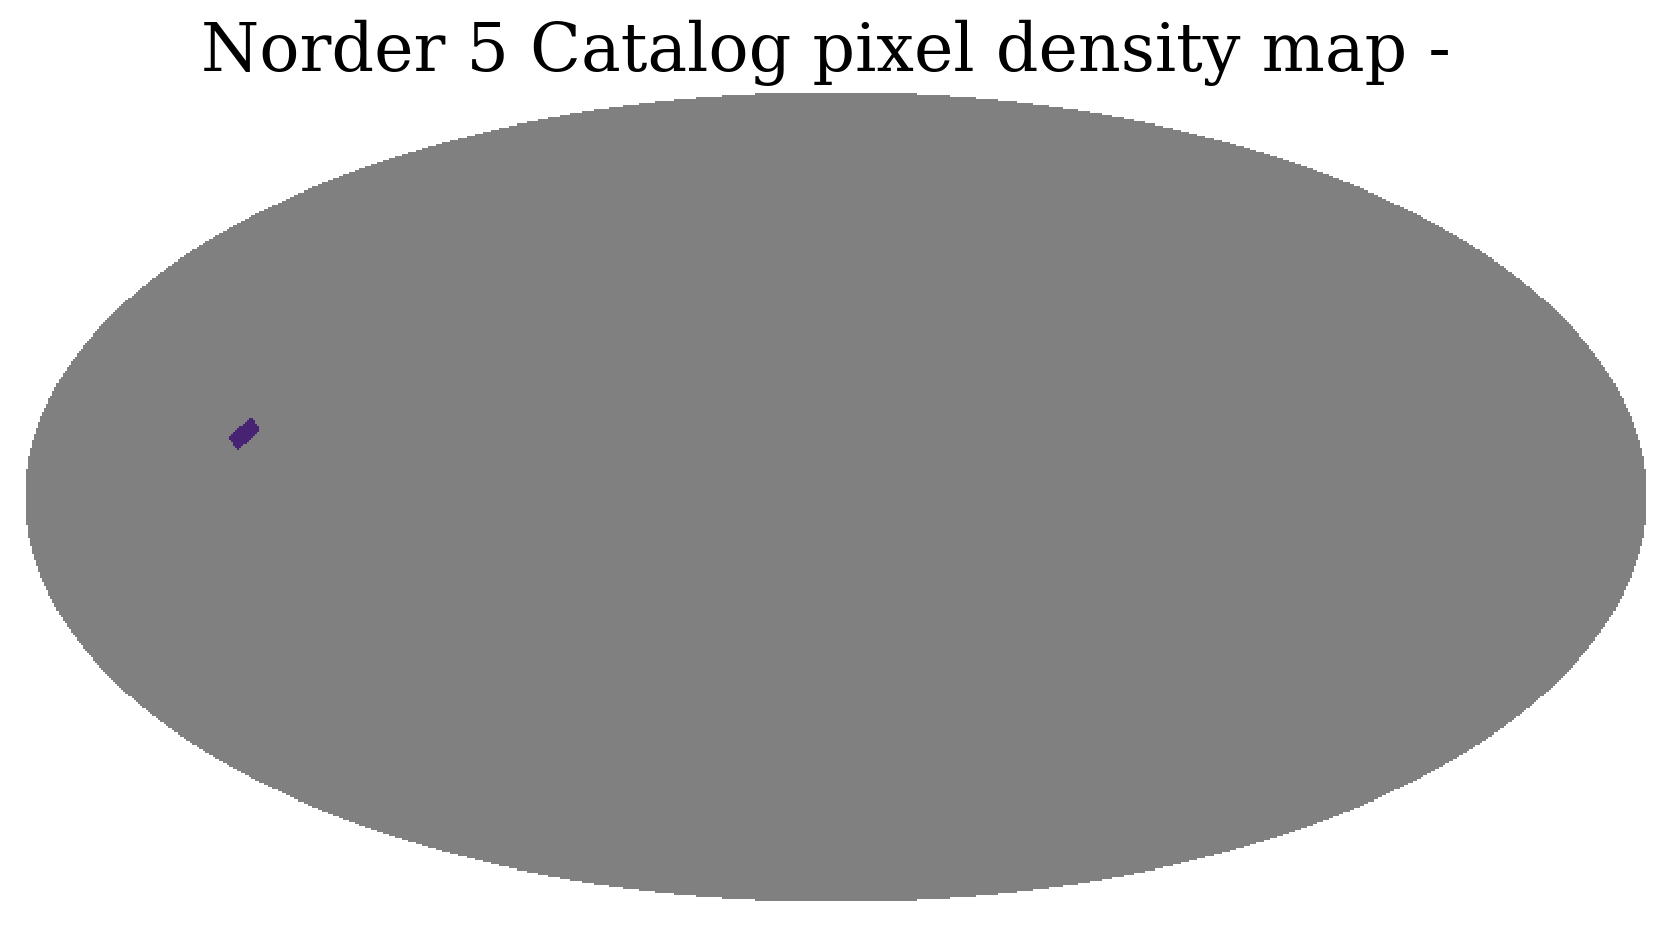

In [11]:
from hipscat.inspection import plot_pixels
plot_pixels(_sample_hips.hc_structure)

### Join sample hips with ZTF sources 

In [12]:
# Peform a join between the crossmatch and the ZTF sources using the PS1 object ID
ss = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/join_catalog_data.py:196: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [14]:
print (f"Number of columns: {len(ss.columns)}")

Number of columns: 18


### Initialize Dask Client

In [15]:
# Initialize dask client with 5 workers
from dask.distributed import Client
client = Client(n_workers=3, memory_limit="auto", threads_per_worker=1)

In [16]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 3,Total memory: 31.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37868,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 3
Started: Just now,Total memory: 31.49 GiB
Comm: tcp://127.0.0.1:35251,Total threads: 1
Dashboard: http://127.0.0.1:45267/status,Memory: 10.50 GiB
Nanny: tcp://127.0.0.1:45122,


## Initialize TAPE `ens`

In [28]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble
ens = Ensemble(client=client) # pass in initialized dask client

In [29]:
ens.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 3,Total memory: 31.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37868,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 3
Started: 3 minutes ago,Total memory: 31.49 GiB
Comm: tcp://127.0.0.1:35251,Total threads: 1
Dashboard: http://127.0.0.1:45267/status,Memory: 10.50 GiB
Nanny: tcp://127.0.0.1:45122,


In [30]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

# Ens to LSDB catalogs
ens.from_lsdb(
    source_catalog=ss, # source catalog
    object_catalog=_sample_hips, # object catalog
    column_mapper=colmap,
    sync_tables=False,
    sorted=True,
    sort=True)

In [27]:
ens.source

,ra_ztf_dr14_,dec_ztf_dr14_,ps1_objid_ztf_dr14_,ra_gaia_,dec_gaia_,parallax_gaia_,_dist_arcsec_,Norder_,Dir_,Npix_,ra_ztf_source,dec_ztf_source,mjd_ztf_source,mag_ztf_source,magerr_ztf_source,band_ztf_source,ps1_objid_ztf_source,catflags_ztf_source
npartitions=30,,,,,,,,,,,,,,,,,,
1194579801160024064,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow]
1194861276136734720,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216816324320165888,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Define Custom Time Series Function

In [31]:
from astropy.timeseries import LombScargle

def compute_optimized_periodogram_grid(x0, oversampling_factor=5, nyquist_factor=3):
    """
    Computes an optimized periodogram frequency grid for a given time series. 
    
    Implemented in https://github.com/astroML/gatspy/blob/71384b8d15531bc01a6b85250a35cd675edccf44/gatspy/periodic/modeler.py#L94

    Parameters:
    - x0 (array-like): The input time axis.
    - oversampling_factor (int, optional): The oversampling factor for frequency grid. Default is 5.
    - nyquist_factor (int, optional): The Nyquist factor for frequency grid. Default is 3.

    Returns:
    - array: The computed optimized periodogram frequency grid.
    """

    # Number of data points in the time series
    num_points = len(x0)

    # Calculate the baseline of the time series
    baseline = np.max(x0) - np.min(x0)

    # Calculate the frequency resolution based on oversampling factor and baseline
    frequency_resolution = 1. / baseline / oversampling_factor

    # Calculate the number of frequencies and the frequency grid
    num_frequencies = int(0.5 * oversampling_factor * nyquist_factor * num_points)
    frequencies = frequency_resolution + frequency_resolution * np.arange(num_frequencies)

    return frequencies


def calc_invNeumann(t, mag, wstd):
    """Calculate the time-weighted inverse Von Neumann stat.
        Source: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    dt = t[1:] - t[:-1]
    dm = mag[1:] - mag[:-1]

    w = (dt) ** -2  # inverse deltat weighted
    eta = np.sum(w * dm**2)
    eta /= np.sum(w) * wstd**2

    return eta**-1


def calc_NormExcessVar(mag, err, N, wmean):
    """    Source: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    stat = np.sum((mag - wmean) ** 2 - err**2)
    stat /= N * wmean**2
    return stat

def calc_features(time, mag, magerr, flag, band):
    """Calculate the skewness and kurtosis of a light curve for good detections in r-band."""

    # TODO: add Pnadas.DataFrame output

    rmv = (band=='r') & (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)

    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]
    
    if len(time_)>0:
        lsp = LombScargle(time_,
                          mag_,
                          magerr_,
                          fit_mean=True,
                          center_data=True,
                          nterms=1, 
                         normalization='standard')
        
        # Determine optimal frequency grid given data...
        f_grid = compute_optimized_periodogram_grid(time,
                                                    oversampling_factor=0.3, nyquist_factor=100)
        power = lsp.power(f_grid)
        period = 1/f_grid
        snr = (max(power)-np.mean(power))/np.std(power)
        
        # Other featues to compute 
        neu = calc_invNeumann(time_, mag_, np.nanstd(mag_))
        noe = calc_NormExcessVar(mag_, magerr_, len(mag_), np.nanstd(mag_))
        var = np.var(mag_)
        var_tar = np.var(mag_)**2
        Nsig = len(mag_[mag_ > np.nanmedian(mag_)])
        Nphot = len(time_)
        
        return period[np.argmax(power)], power[np.argmax(power)], snr, np.nanmean(mag), neu, noe, var, var_tar, Nsig, Nphot     
    else:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [32]:
res2 = ens.batch(
    calc_features, "mjd_ztf_source", "mag_ztf_source", 
    'magerr_ztf_source', 
    'catflags_ztf_source', 'band_ztf_source')

Using generated label, result_1, for a batch result.


In [33]:
%%time
table = res2.compute()

/tmp/ipykernel_24216/2151131030.py:78: RuntimeWarning: invalid value encountered in scalar subtract
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_24216/2151131030.py:25: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_24216/2151131030.py:29: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_24216/2151131030.py:43: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_24216/2151131030.py:52: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_24216/2151131030.py:25: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_24216/2151131030.py:29: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_24216/2151131030.py:43: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_24216/215113

In [68]:
table

,result
_hipscat_index,
1195635224533270528,"(0.9643778304721017, 0.10316628270969766, 7.17..."
1195635242824630272,"(0.48847833913043526, 0.037420639831269295, 7...."
1195635245353795584,"(0.9971335176211479, 0.046146617516834826, 12...."
1195681424221405184,"(0.16127489027431383, 0.03531639101905504, 8.2..."
1195681461315829760,"(0.9647050588235263, 0.29092834402048545, 4.39..."
...,...
1216416656180379648,"(0.46674833368420854, 0.31049061528945415, 4.9..."
1216420518253559808,"(0.4368997948969582, 0.24806338203078887, 4.98..."
1216420530047942656,"(0.05474647575281173, 0.03101807392099944, 6.6..."


In [69]:
%%time
table[['period', 'power', 'snr', 'mu_mag', 
      'neu', 'noe', 'var', 'var_tar', 'Nsig', 'Nphot']] = pd.DataFrame(table['result'].tolist(), index=table.index)

CPU times: user 158 ms, sys: 45.8 ms, total: 204 ms
Wall time: 188 ms


In [70]:
table.drop(columns=['result'], inplace=True)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


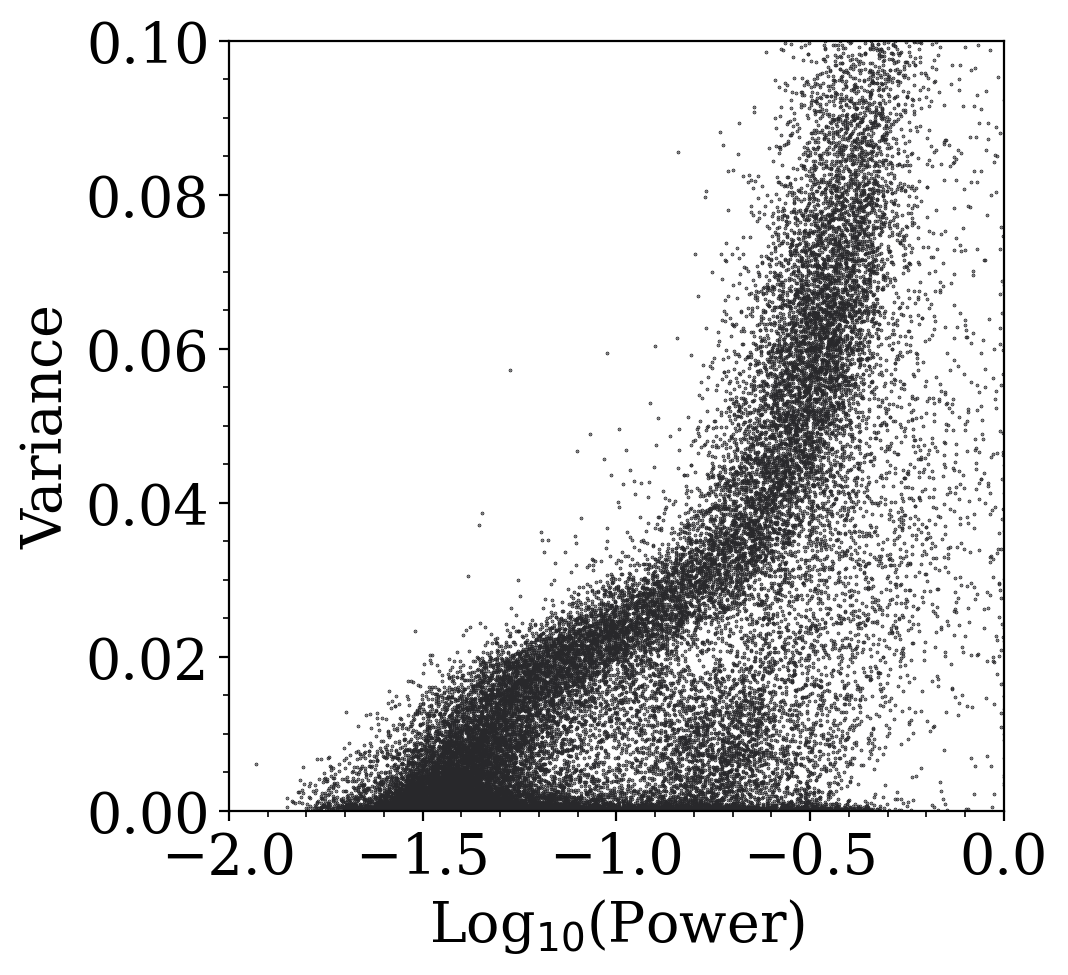

In [71]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(table['power']), table['var'], s=0.1, color="#28282B")
plt.ylim(0, 0.1)
plt.xlim(-2, 0)
plt.xlabel("Log$_{10}$(Power)")
plt.ylabel("Variance")
plt.minorticks_on()

## Plot Lightcurve